# Data exploration

### Setup

In [ ]:
!pip install -r requirements.txt

### Getting data from s3

In [116]:
import pandas as pd
import numpy as np
import awswrangler as wr
import matplotlib.pyplot as plt

In [117]:
bucket_name = 'ds-benedict-tmp'
file_name = 'ds_interview_data.csv'
file_path = f's3://{bucket_name}/{file_name}'

df = wr.s3.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21960 entries, 0 to 21959
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   postcode                 21960 non-null  object 
 1   bedrooms                 21960 non-null  int64  
 2   main_type                21960 non-null  object 
 3   second_level_type        21938 non-null  object 
 4   footprint_area_sqm       21951 non-null  float64
 5   abshmin                  21943 non-null  float64
 6   absh2                    21941 non-null  float64
 7   abshmax                  21943 non-null  float64
 8   relh2                    21941 non-null  float64
 9   relhmax                  21943 non-null  float64
 10  internal_floor_area_sqm  21806 non-null  float64
 11  chain_1_hash             17152 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.0+ MB


### Investigation 
- [x] Check for Null values
    - There are quite a few missing values in **chain_1_hash** (we can keep it along until observing its informativeness else we can drop this column. 
    - For other columns nan values are low proportion of total so we can potentially just drop nan rows from these columns for simplicity
- [x] Check for correlated features and drop some of them
- [ ] Check for non informative features (by variance)
- [ ] Target variable analysis
- [ ] Mutual info regression
- [ ] Start with low penalisation on parametric models as they may naturally underfit on this sufficiently large dataset
- [ ] Check for most informative features by coefficients (Poisson Regression)
- [ ] Try RFECV (Poisson regression)
- [ ] Try Boosting and check feature importance. Compare with previous results

In [126]:
target = 'bedrooms'
features = df.columns.difference([target])

df_non_na = df.dropna(subset=features.difference(['chain_1_hash'])) # Drop na values using all feature columns except chain_1_hash
X,y = df_non_na[features], df_non_na[target]

### Checking correlation between features (using numeric features only)

We can identify collinearity between features and drop some of them to avoid instabilities in the models later on

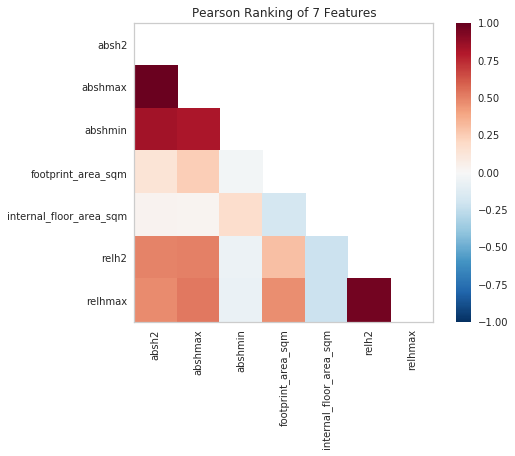

,absh2,abshmax,abshmin,footprint_area_sqm,internal_floor_area_sqm,relh2,relhmax
0,29.7,30.7,18.1,95.26830,81.0,11.6,12.6
1,25.1,28.8,18.2,67.70440,165.0,6.9,10.6
2,25.3,29.0,18.4,84.70275,184.0,6.9,10.6
3,24.2,28.7,18.5,89.63606,218.0,5.7,10.2
4,25.3,28.8,18.7,71.91312,172.0,6.6,10.1
...,...,...,...,...,...,...,...
21955,16.4,18.1,9.5,81.66702,68.0,6.9,8.6
21956,18.5,22.0,13.6,85.30910,66.0,4.9,8.4
21957,28.9,31.0,19.0,68.82183,60.0,9.9,12.0
21958,28.4,31.7,22.4,86.00033,64.0,6.0,9.3


In [127]:
from yellowbrick.features import Rank2D

X_numeric_ = X.select_dtypes(np.double)
visualizer = Rank2D(algorithm='pearson')
visualizer.fit_transform_show(X_numeric_)


- It makes sense that relh2 and relhmax are correlated and so are absh2 and abshmax. For these variables we can potentially just take one and drop the other 
- To a significant degree abshmin happens to be correlated with absh2 and abshmax. We can explore this in slight more detail before making a decision

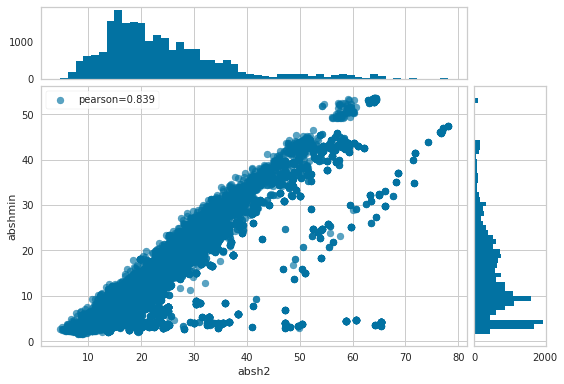

,absh2,abshmax,abshmin,footprint_area_sqm,internal_floor_area_sqm,relh2,relhmax
0,29.7,30.7,18.1,95.26830,81.0,11.6,12.6
1,25.1,28.8,18.2,67.70440,165.0,6.9,10.6
2,25.3,29.0,18.4,84.70275,184.0,6.9,10.6
3,24.2,28.7,18.5,89.63606,218.0,5.7,10.2
4,25.3,28.8,18.7,71.91312,172.0,6.6,10.1
...,...,...,...,...,...,...,...
21955,16.4,18.1,9.5,81.66702,68.0,6.9,8.6
21956,18.5,22.0,13.6,85.30910,66.0,4.9,8.4
21957,28.9,31.0,19.0,68.82183,60.0,9.9,12.0
21958,28.4,31.7,22.4,86.00033,64.0,6.0,9.3


In [128]:
from yellowbrick.features import JointPlotVisualizer

columns = ['absh2', 'abshmin']
visualizer = JointPlotVisualizer(columns=columns)
visualizer.fit_transform_show(X_numeric_,y)


Looking at the plot it appears that `abshmin` encodes slightly more information than absh2 being bimodal so we can keep this and **drop absh2 and abshmax**. We will also keep `relhmax` and these both should approximately capture the effect of elevation and build height

In [129]:
numeric_columns_to_drop = ['relh2', 'absh2', 'abshmax']
numeric_features = X_numeric_.columns.difference(numeric_columns_to_drop)


### Checking informativeness in features

In [174]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

X,y = df.dropna()[features], df.dropna()[target]

high_cardinality_features = ['chain_1_hash', 'postcode']
categorical_features = [f for f in df.select_dtypes(['object']).columns if (f not in high_cardinality_features)]

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder()

column_transformer = ColumnTransformer([('numeric_data', 'passthrough', numeric_features), 
                                       ('categorical_data', one_hot_encoder, categorical_features),
                                       ('high_cardinality_features', ordinal_encoder, high_cardinality_features)])

Xt = column_transformer.fit_transform(X)

FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaceffb8d0>,
                   color=None, feature_index=None, feature_names=None,
                   labels=['abshmin', 'footprint_area_sqm',
                           'internal_floor_area_sqm', 'relhmax', 'x0_FLA',
                           'x0_HSE', 'x1_BLK', 'x1_CNV', 'x1_DET', 'x1_SEM',
                           'x1_TERR', 'chain_1_hash', 'postcode'],
                   method='mutual_info-regression', sort=False)

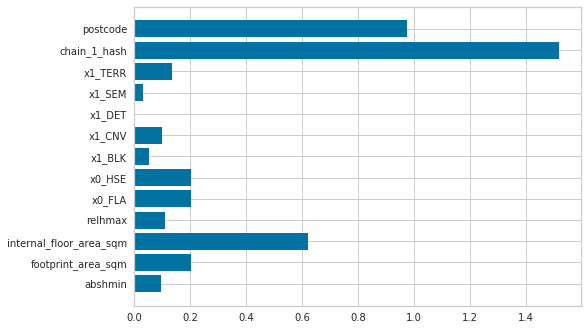

In [181]:
from yellowbrick.target import FeatureCorrelation

feature_names = list(numeric_features) + list(column_transformer.named_transformers_['categorical_data'].get_feature_names()) + high_cardinality_features
discrete = [False]*len(numeric_features) + [True]*(Xt.shape[1] - len(numeric_features))
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=feature_names)
visualizer.fit(Xt, y, discrete_features=discrete, random_state=0)

Earlier it was suggested that we may drop `chain_1_hash` because it has many NaN values which can't realistically be imputed. However, this column has much information about target variable and instead of losing all that information we prefer to model houses that do not have this information separately (or working with models that can incorporate missing values natively).

### Modelling Assumptions

- We're modelling count data so some variant of Poisson regression is appropriate to avoid negative values prediction and allow non normal error distribution

- Poisson may be okay since mean of target is nearly equal to its variance

- Since prediction off by even 1 is considered bad it should be weighted equally irrespective of misprediction when predicting 10 bedrooms or 1 bedroom. Hence MSE is a good choice for error metric (since it doesn't scale with predicted value but only with error itself)

- Although MSE does assume target variable to be normally distributed so using poisson loss may be better

